## Check GPU

Google colab offers free GPUs, however not all of them are compatiable with mixed precession training
* Tesla T4 is compatible


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-35f41c82-396b-15f3-3edf-861acf270447)


## Get helper Functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-23 05:12:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-23 05:12:25 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to downlaod datasets

In [ ]:
# GEt tensorflow datasets
import tensorflow_datasets as tfds

In [ ]:
datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
#Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info
for image, label in train_one_sample:
  print(f"""
  Image Shape : {image.shape}
  Image datatype : {image.dtype}
  Target class from Food101(tensor form) : {label}
  Class name (str form) : {class_names[label.numpy()]}
  """)


  Image Shape : (341, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class from Food101(tensor form) : 98
  Class name (str form) : tiramisu
  


In [ ]:
image

<tf.Tensor: shape=(341, 512, 3), dtype=uint8, numpy=
array([[[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [  0,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   5,   1]],

       ...,

       [[143,  75,  10],
        [149,  81,  16],
        [150,  85,  19],
        ...,
        [162,  88,  25],
        [150,  79,  17],
        [135,  65,   5]],

       [[144,  76,  11],
        [152,  84,  19],
        [145,  80,  16],
        ...,
        [126,  60,  12],
        [111,  50,   3],
        [ 95,  37,   0]],

       [[145,  77,  14],
        [150,  82,  19],
        [139,  74,  10],
        ...,
        [ 89,  35,   

In [ ]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

(-0.5, 511.5, 340.5, -0.5)

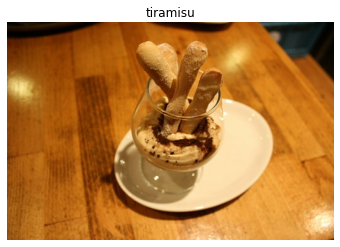

In [ ]:
### Plot an image
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create Preprocessig functions for our data

* data is in `uint8` datatype
* different sizes tensors
* not scaled

Since we are using EficientNetBX pretrained model we don't need to rescale

means our function do only
1. Reshape
2.convert uint8 to float32

In [ ]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape,img_shape])
  #image = image/255. not required with EfficientNetBX
  return tf.cast(image, tf.float32), label

In [ ]:
# preprocess a single sample image and check the outputs

preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing \n{image[:2]}... \nShape : {image.shape} ,\ Dtypes {image.dtype}\n")
print(f"Image after preprocessing \n{preprocessed_img[:2]}... \nShape : {preprocessed_img.shape} ,\ Dtypes {preprocessed_img.dtype}")

Image before preprocessing 
[[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [0 3 0]
  [0 4 0]
  [0 4 0]]

 [[2 2 0]
  [2 2 0]
  [3 3 1]
  ...
  [1 3 0]
  [0 4 0]
  [0 4 0]]]... 
Shape : (341, 512, 3) ,\ Dtypes <dtype: 'uint8'>

Image after preprocessing 
[[[2.         2.         0.        ]
  [2.947226   2.947226   0.947226  ]
  [4.         5.         0.        ]
  ...
  [1.         3.         0.        ]
  [0.01865775 2.757497   0.        ]
  [0.         4.         0.        ]]

 [[4.350446   5.1339283  0.7834821 ]
  [4.566964   5.350446   1.        ]
  [4.783482   5.783482   0.7834821 ]
  ...
  [1.         3.         0.        ]
  [0.7989505  2.7989504  0.        ]
  [0.         4.2798424  0.27984235]]]... 
Shape : (224, 224, 3) ,\ Dtypes <dtype: 'float32'>


## Batch and prepare our dataset

We're going to make our input data pipeline run really fast


In [ ]:
#Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img,num_parallel_calls = tf.data.AUTOTUNE)  #tf.data.AUTOTUNE means collab use all CPU to do this map
# Shuffle train_data and turn into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


#Map preprocessing function to test data
test_data = test_data.map(preprocess_img,num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

"Hey, tensorflow, ,map this preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure you prepare new batches(prefetch) whilst the model is looking through(finding patterns) the current batch"

## Create Modelling Callbacks

In [ ]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

#Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

Setup Mixed Precision Training



In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

In [ ]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Builf features extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
input_shape=(224,224,3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
#if your model haven't rescale layer use the below layer
# x = preprocessing.Rescaling(1./255)(x)

x=base_model(inputs,training=False)
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])  #labels are not one hot encoded

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
for layer in model.layers:
  print(f"layer `{layer.name}` is trainable : {layer.trainable} has datatype : `{layer.dtype}` policy is `{layer.dtype_policy}`")

layer `input_layer` is trainable : True has datatype : `float32` policy is `<Policy "float32">`
layer `efficientnetb0` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `global_average_pooling2d_1` is trainable : True has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `dense_1` is trainable : True has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `softmax_float32` is trainable : True has datatype : `float32` policy is `<Policy "float32">`


In [ ]:
for layer in model.layers[1].layers:
  print(f"layer `{layer.name}` is trainable : {layer.trainable} has datatype : `{layer.dtype}` policy is `{layer.dtype_policy}`")

layer `input_2` is trainable : False has datatype : `float32` policy is `<Policy "float32">`
layer `rescaling_2` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `normalization_1` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `rescaling_3` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `stem_conv_pad` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `stem_conv` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `stem_bn` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `stem_activation` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `block1a_dwconv` is trainable : False has datatype : `float32` policy is `<Policy "mixed_float16">`
layer `block1a_bn` is trainable : False has datatype : `float32` policy is `

In [ ]:
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=len(test_data),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "101_food_classes_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/101_food_classes_feature_extract/20230323-071931


Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7181 - accuracy: 0.5826

2368/2368 [==============================] - 267s 106ms/step - loss: 1.7181 - accuracy: 0.5826 - val_loss: 1.1408 - val_accuracy: 0.6970
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1995 - accuracy: 0.6888

2368/2368 [==============================] - 252s 106ms/step - loss: 1.1994 - accuracy: 0.6888 - val_loss: 1.0388 - val_accuracy: 0.7205
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0539 - accuracy: 0.7260

2368/2368 [==============================] - 222s 93ms/step - loss: 1.0539 - accuracy: 0.7260 - val_loss: 0.9935 - val_accuracy: 0.7295


In [ ]:
#Evalute on whole test data
results_feature_extract_model = model.evaluate(test_data)

790/790 [==============================] - 54s 68ms/step - loss: 0.9935 - accuracy: 0.7295
